# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Охотин Андрей

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

import torchvision
from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

import os
from skimage import io
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# path to directory with this file
base_path = "/content/drive/My Drive/Colab Notebooks/mmp/task2/"

In [5]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.fimages = []
        self.images_dir = images_dir
        for root, dirs, files in os.walk(images_dir):  
            for filename in files:
                self.fimages.append(filename)
        self.masks_dir = target_dir
        if target_dir is not None:
            self.fmasks = []
            for root, dirs, files in os.walk(target_dir):  
                for filename in files:
                    self.fmasks.append(filename)
        else:
            self.fmasks = None
        self.fimages = sorted(self.fimages)
        self.fmasks = sorted(self.fmasks)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.fimages)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir, self.fimages[idx])
        mask_name = os.path.join(self.masks_dir, self.fmasks[idx])
        sample = (
            np.asarray(Image.open(img_name)) / 255,
            (np.asarray(Image.open(mask_name)) > 0).astype(float)
        )
        if self.transforms:
            sample = self.transforms(sample)
        
        return sample

In [6]:
my_data = PhotosDataset(base_path + "people_data/train", base_path + "people_data/train_mask")
my_data.fmasks[:5], my_data.fimages[:5]

(['1.png', '10.png', '100.png', '1000.png', '1001.png'],
 ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg'])

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [7]:
from torch.distributions.uniform import Uniform

class Transform(object):
    
    def __init__(self, garant_transforms, random_transforms=None, p=None):
        self.garant_transforms = garant_transforms
        self.random_transforms = random_transforms
        self.uniform = Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
        self.p = p
    
    def random_apply(self):
        s = self.uniform.sample().item()
        return s < self.p
    
    def __call__(self, obj):
        
        if self.random_transforms is not None:
            idx = 0
            for tr in self.random_transforms:
                if self.random_apply():
                    obj = tr(obj)
                    
        if self.garant_transforms is not None:
            for tr in self.garant_transforms:
                obj = tr(obj)
                
        return obj


In [8]:
class HorizontalFlip(object):

    def __call__(self, img):
        img_cpy = img[0].copy()[:,::-1]
        mask_cpy = img[1].copy()[:,::-1]
        return (img_cpy, mask_cpy)


In [9]:
class PartCut(object):
    
    def __init__(self, bounds_sz=None):
        self.bounds_sz = bounds_sz
    
    def take_random_bounds(self, sz):
        vidx = np.random.randint(sz[0], size=2)
        hidx = np.random.randint(sz[1], size=2)
        return vidx.min(), vidx.max(), hidx.min(), hidx.max()

    def __call__(self, img, mask=None):
        img_cpy = img[0].copy()
        uv, dv, lh, rh = self.take_random_bounds(img_cpy.shape)
        if dv - uv > self.bounds_sz[0]:
            uv = dv - self.bounds_sz[0]
        if rh - lh > self.bounds_sz[1]:
            lh = rh - self.bounds_sz[1]
        img_cpy[uv:dv, lh:rh, :] = 0
        return (img_cpy, img[1])


In [10]:
class ReduceBrightness(object):
    
    def __init__(self, reduce_param):
        self.rp = reduce_param
    
    def __call__(self, img):
        return ((img[0] * self.rp), img[1])
    

In [11]:
class ChangeBackground(object):
    
    def __init__(self, img_list):
        self.backgrounds = img_list
        
    def take_random_background(self):
        return self.backgrounds[np.random.randint(len(self.backgrounds))]
    
    def __call__(self, img):
        background = self.take_random_background()
        img_cpy = img[0].copy()
        idx = (1 - img[1]).astype(bool)
        img_cpy[idx] = background[idx]
        return (img_cpy, img[1])
        

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [12]:
class ToTensor(object):
    
    def __call__(self, img):
        tensor_img = torch.tensor([list(img[0][:,:,0]), list(img[0][:,:,1]), list(img[0][:,:,2])], dtype=torch.float)
        tensor_mask = torch.tensor(list(img[1]), dtype=torch.float)
        return (tensor_img, tensor_mask)
        

In [13]:
class Normalize(object):
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, img):
        img_cpy = img[0].copy()
        img_cpy = (img_cpy - self.mean) / self.std
        return (img_cpy, img[1])


In [14]:
my_data = PhotosDataset(
    base_path + "people_data/train", 
    base_path + "people_data/train_mask", 
    transforms=Transform(
        garant_transforms=[
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

backgrounds = []
for i in range(100):
    backgrounds.append(my_data[i][0].transpose(0, 1).transpose(1, 2).numpy())


In [15]:
DATA_PATH = base_path + 'people_data/'

img_tr = Transform(
    garant_transforms=[
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensor()
    ],
    random_transforms=[
        HorizontalFlip(),
        PartCut((30, 30)),
        ReduceBrightness(0.7),
        ChangeBackground(backgrounds)
    ],
    p = 0.1
)

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= img_tr
)

test_tr = Transform(
    garant_transforms=[
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensor()
    ]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms= test_tr
)

При таком выборе p = 0.1, в моей реализации, вероятность того, что будет применено хотя бы одно из преобразований, примерно равна 35%.

Функция для отображения изображения:

In [16]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = torch.tensor(mask_img[0]).transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')
    
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

In [17]:
DATA_PATH = base_path + 'people_data/'

data_set = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= Transform(
        garant_transforms=[
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


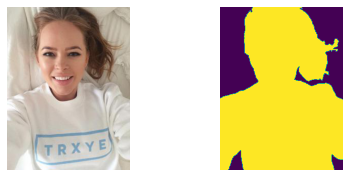

In [18]:
show_idx_image(data_set, 0)

In [19]:
DATA_PATH = base_path + 'people_data/'

data_set = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= Transform(
        garant_transforms=[
            HorizontalFlip(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


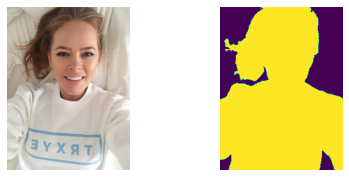

In [20]:
show_idx_image(data_set, 0)

In [21]:
DATA_PATH = base_path + 'people_data/'

data_set = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= Transform(
        garant_transforms=[
            PartCut((40, 40)),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


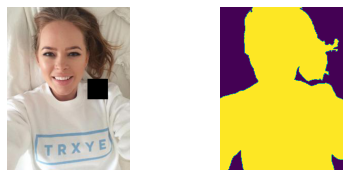

In [22]:
show_idx_image(data_set, 0)

In [23]:
DATA_PATH = base_path + 'people_data/'

data_set = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= Transform(
        garant_transforms=[
            ReduceBrightness(0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


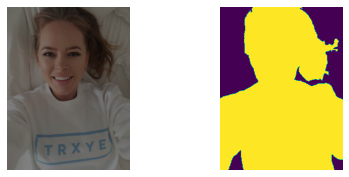

In [24]:
show_idx_image(data_set, 0)

In [25]:
DATA_PATH = base_path + 'people_data/'

data_set = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= Transform(
        garant_transforms=[
            ChangeBackground(backgrounds),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensor()
        ]
    )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


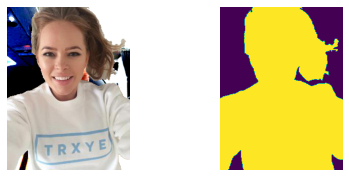

In [26]:
show_idx_image(data_set, 0)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [27]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [28]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        right_probs = 2 * (logits * true_labels).sum(axis=2).sum(axis=1)
        all_probs = (logits + true_labels).sum(axis=2).sum(axis=1) + self.eps
        dice_loss = 1. -  right_probs / all_probs
        
        if self.reduction == 'sum':
            loss_value = dice_loss.sum()
        elif self.reduction == 'mean':
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [29]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [30]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [31]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [32]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [33]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [34]:
def IoU(pred, target):
    y_pred = (pred.clone().detach().numpy() > 0.5).astype(int)
    y_true = target.clone().detach().numpy().astype(int)
    m = (y_pred * y_true).sum() / (y_pred + y_true > 0).astype(int).sum()
    return torch.tensor(m)


In [35]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = []
    iou = []
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            outputs = net(images).to('cpu').view(-1, 320, 240)

            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct.append(float(val_criterion(outputs, labels).detach()))
            iou.append(float(IoU(outputs, labels).detach()))
    
    mean_loss = loss / total
    metric = np.array(correct).mean()
    iou = np.array(iou).mean()
    
    return mean_loss, metric, iou

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [36]:
def accuracy_mean(pred, target):
    y_pred = (pred.clone().detach().numpy() > 0.5).astype(int)
    y_true = target.clone().detach().numpy().astype(int)
    accur = (y_pred == y_true).mean()
    return torch.tensor(accur)


In [37]:
def IoU(pred, target):
    # how accuracy model find segment of image
    y_pred = (pred.clone().detach().numpy() > 0.5).astype(int)
    y_true = target.clone().detach().numpy().astype(int)
    m = (y_pred * y_true).sum() / (y_pred + y_true > 0).astype(int).sum()
    return torch.tensor(m)


In [38]:
def train(model, criterion, optimizer, train_loader, test_loader, val_criterion, epochs, device='cpu', show=True):
    test_losses, test_metrics, test_iou, train_losses, train_metrics, train_iou = [], [], [], [], [], []
    try:
        for epoch in range(epochs):
            model.train()
            local_loss = 0.
            correct = []
            iou_crit = []
            total = 0.
            for data in train_loader:
                images, labels = data
                images = images.to(device)

                outputs = model(images).to('cpu').view(-1, 320, 240)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                total += labels.size(0)
                local_loss += float(loss.detach())
                iou_crit.append(float(IoU(outputs, labels).detach()))
                correct.append(float(val_criterion(outputs, labels).detach()))
                
            eval_loss, eval_metric, eval_iou = evaluate_net(model, test_loader, criterion, val_criterion, device)
            train_loss = local_loss / total
            train_metric = np.array(correct).mean()
            iou = np.array(iou_crit).mean()
            if show:
                out = "Epoch: " + "%3d" % (epoch + 1)
                out += " " + f"  Loss / Metric / IoU:  train: {(train_loss):.3f}/{(train_metric):.3f}/{(iou):.3f}"
                out += f"  test: {(eval_loss):.3f}/{(eval_metric):.3f}/{(eval_iou):.3f}"
                print(out)

            test_losses.append(eval_loss)
            test_metrics.append(eval_metric)
            test_iou.append(eval_iou)
            train_losses.append(train_loss)
            train_metrics.append(train_metric)
            train_iou.append(iou)

    except KeyboardInterrupt:
        pass  

    train_res = [test_losses, test_metrics, test_iou, train_losses, train_metrics, train_iou]
    return model, train_res

In [39]:
#CUDA scripts

print("Available CUDAs: ", torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:  ", device)
cuda_1 = device

Available CUDAs:  1
Current device:   cuda:0


In [40]:
def net_predict(net, data_set, idx):
  with torch.no_grad():
      input_img = data_set[idx][0].view(1,3,320,240).to(cuda_1)
      out = net.forward(input_img).to('cpu')
      base_probs = out.numpy().reshape(320,240)
      preds = (base_probs > 0.5).astype(int)
      true_mask = data_set[idx][1].numpy().reshape(320,240)

      fig = plt.figure(figsize=(13, 4))

      ax = fig.add_subplot(131)
      plt.title("Probability", fontsize=16)
      plt.axis('off')
      plt.imshow(base_probs)
    
      ax = fig.add_subplot(132)
      plt.title("Round prediction", fontsize=16)
      plt.axis('off')
      plt.imshow(preds)
    
      ax = fig.add_subplot(133)
      plt.title("True mask", fontsize=16)
      plt.axis('off')
      plt.imshow(true_mask)

      plt.show()
      print("Accuracy:", f"{accuracy_mean(torch.tensor(preds), torch.tensor(true_mask)):.3f}")


## BCE и Dice

In [ ]:
bce_unet = UNet()
bce_unet.to(cuda_1)
criterion = nn.BCEWithLogitsLoss()
val_criterion = accuracy_mean
optimizer = Adam(bce_unet.parameters(), weight_decay=1e-5, lr=1e-5)

bce_unet, bce_train_res = train(
    model=bce_unet, 
    criterion=criterion, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:    1  Loss / Metric / IoU: train: 0.060/0.737/0.582 test: 0.033/0.896/0.843
Epoch:    2  Loss / Metric / IoU: train: 0.029/0.902/0.845 test: 0.028/0.904/0.850
Epoch:    3  Loss / Metric / IoU: train: 0.026/0.914/0.861 test: 0.027/0.916/0.870
Epoch:    4  Loss / Metric / IoU: train: 0.024/0.921/0.872 test: 0.025/0.916/0.868
Epoch:    5  Loss / Metric / IoU: train: 0.022/0.926/0.880 test: 0.024/0.924/0.881
Epoch:    6  Loss / Metric / IoU: train: 0.021/0.930/0.886 test: 0.024/0.923/0.878
Epoch:    7  Loss / Metric / IoU: train: 0.020/0.935/0.894 test: 0.023/0.920/0.872
Epoch:    8  Loss / Metric / IoU: train: 0.019/0.939/0.900 test: 0.022/0.934/0.897
Epoch:    9  Loss / Metric / IoU: train: 0.018/0.942/0.906 test: 0.021/0.934/0.895
Epoch:   10  Loss / Metric / IoU: train: 0.017/0.946/0.912 test: 0.021/0.934/0.894
Epoch:   11  Loss / Metric / IoU: train: 0.016/0.949/0.916 test: 0.022/0.939/0.905
Epoch:   12  Loss / Metric / IoU: train: 0.015/0.952/0.921 test: 0.020/0.941/0.907
Epoc

In [ ]:
dice_unet = UNet()
dice_unet.to(cuda_1)
dice = DiceLoss(reduction="mean")
val_criterion = accuracy_mean
optimizer = Adam(dice_unet.parameters(), weight_decay=1e-5, lr=1e-5)

dice_unet, dice_train_res = train(
    model=dice_unet, 
    criterion=dice, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:    1  Loss / Metric / IoU: train: 0.038/0.619/0.514 test: 0.026/0.845/0.791
Epoch:    2  Loss / Metric / IoU: train: 0.016/0.877/0.818 test: 0.011/0.903/0.851
Epoch:    3  Loss / Metric / IoU: train: 0.011/0.905/0.853 test: 0.010/0.913/0.867
Epoch:    4  Loss / Metric / IoU: train: 0.010/0.916/0.868 test: 0.009/0.916/0.871
Epoch:    5  Loss / Metric / IoU: train: 0.009/0.923/0.878 test: 0.009/0.920/0.877
Epoch:    6  Loss / Metric / IoU: train: 0.008/0.927/0.885 test: 0.009/0.921/0.876
Epoch:    7  Loss / Metric / IoU: train: 0.008/0.932/0.892 test: 0.008/0.925/0.884
Epoch:    8  Loss / Metric / IoU: train: 0.007/0.935/0.897 test: 0.009/0.924/0.880
Epoch:    9  Loss / Metric / IoU: train: 0.007/0.940/0.903 test: 0.008/0.930/0.890
Epoch:   10  Loss / Metric / IoU: train: 0.007/0.942/0.907 test: 0.007/0.934/0.897
Epoch:   11  Loss / Metric / IoU: train: 0.006/0.946/0.913 test: 0.007/0.936/0.900
Epoch:   12  Loss / Metric / IoU: train: 0.006/0.949/0.918 test: 0.007/0.936/0.900
Epoc

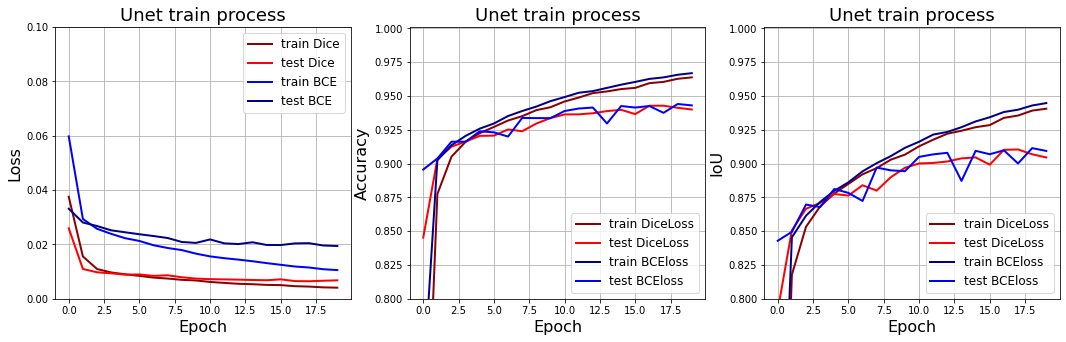

In [ ]:
bce_test_losses, bce_test_metrics, bce_test_iou, bce_train_losses, bce_train_metrics, bce_train_iou = bce_train_res
dice_test_losses, dice_test_metrics, dice_test_iou, dice_train_losses, dice_train_metrics, dice_train_iou = dice_train_res
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(131)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.ylim(0.0, 0.1)
ax.grid()
plt.plot(dice_train_losses, label="train Dice", color="darkred", linewidth=2)
plt.plot(dice_test_losses, label="test Dice", color="red", linewidth=2)
plt.plot(bce_train_losses, label="train BCE", color="blue", linewidth=2)
plt.plot(bce_test_losses, label="test BCE", color="darkblue", linewidth=2)
ax.legend(loc=1, fontsize=12)


ax = fig.add_subplot(132)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.ylim(0.8,1.001)
ax.grid()
plt.plot(dice_train_metrics, label="train DiceLoss", color="darkred", linewidth=2)
plt.plot(dice_test_metrics, label="test DiceLoss", color="red", linewidth=2)
plt.plot(bce_train_metrics, label="train BCEloss", color="darkblue", linewidth=2)
plt.plot(bce_test_metrics, label="test BCEloss", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)


ax = fig.add_subplot(133)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("IoU", fontsize=16)

plt.ylim(0.8,1.001)
ax.grid()
plt.plot(dice_train_iou, label="train DiceLoss", color="darkred", linewidth=2)
plt.plot(dice_test_iou, label="test DiceLoss", color="red", linewidth=2)
plt.plot(bce_train_iou, label="train BCEloss", color="darkblue", linewidth=2)
plt.plot(bce_test_iou, label="test BCEloss", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)

plt.show()

## Предсказания Unet с функцией потерь BCEWithlogitsloss

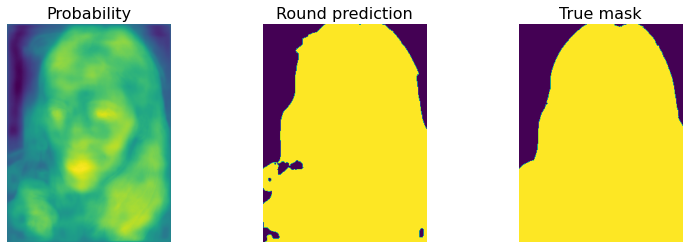

Accuracy: 0.972


In [ ]:
net_predict(bce_unet, test_dataset, 4)

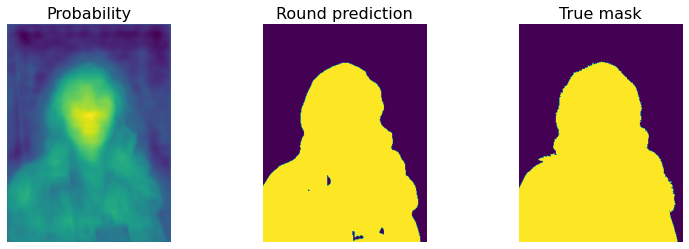

Accuracy: 0.985


In [ ]:
net_predict(bce_unet, test_dataset, 30)

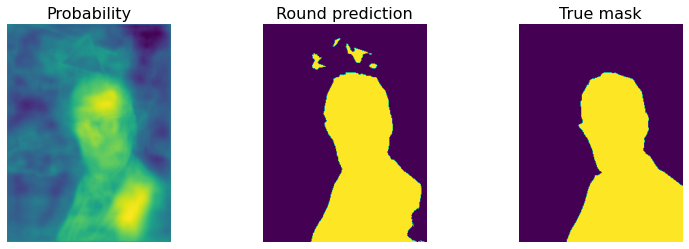

Accuracy: 0.965


In [ ]:
net_predict(bce_unet, test_dataset, 120)

## Предсказание Unet с функций потерь DiceLoss

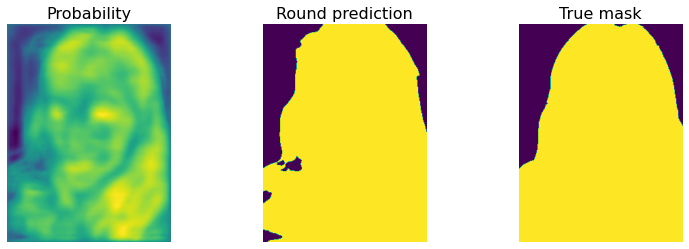

Accuracy: 0.970


In [ ]:
net_predict(dice_unet, test_dataset, 4)

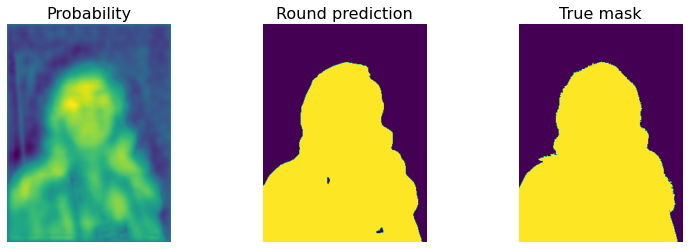

Accuracy: 0.989


In [ ]:
net_predict(dice_unet, test_dataset, 30)

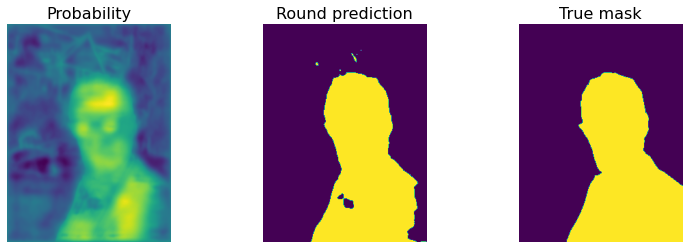

Accuracy: 0.968


In [ ]:
net_predict(dice_unet, test_dataset, 120)

Unet, обученный с функцией потерь BCEwithlogits и Diceloss, достаточно точно выделяет положение сегмента. Отличие находится в целостности сегмента и в наличие выбросов (небольших областей, выделенных, как часть сегмента). Использование DiceLoss дает более целостные сегменты изображений, чем у BCEwithlogits, что можно заметить в очевидной смысловой разнице этих функций потерь.

## Сумма функций потерь с разными коэффициентами

In [42]:
class ModifiedSumLoss(nn.Module):
    def __init__(self, loss1, loss2, coef1=0.5, coef2=0.5):
        super().__init__()
        self.loss1 = loss1
        self.loss2 = loss2
        self.coef1 = coef1
        self.coef2 = coef2
        
    def forward(self, logits, true_labels):
        loss1_value = self.loss1(logits, true_labels)
        loss2_value = self.loss2(logits, true_labels)
        loss = self.coef1 * loss1_value + self.coef2 * loss2_value
        return loss

In [43]:
modif_unet = UNet()
modif_unet.to(cuda_1)
criterion = ModifiedSumLoss(nn.BCEWithLogitsLoss(), DiceLoss(reduction="mean"))
val_criterion = accuracy_mean
optimizer = Adam(modif_unet.parameters(), weight_decay=1e-5, lr=1e-5)

modif_unet, modif_train_res = train(
    model=modif_unet, 
    criterion=criterion, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:   1   Loss / Metric / IoU:  train: 0.050/0.737/0.589  test: 0.026/0.888/0.832
Epoch:   2   Loss / Metric / IoU:  train: 0.023/0.902/0.847  test: 0.021/0.910/0.860
Epoch:   3   Loss / Metric / IoU:  train: 0.020/0.915/0.865  test: 0.020/0.917/0.873
Epoch:   4   Loss / Metric / IoU:  train: 0.018/0.922/0.876  test: 0.019/0.918/0.871
Epoch:   5   Loss / Metric / IoU:  train: 0.017/0.928/0.884  test: 0.018/0.924/0.881
Epoch:   6   Loss / Metric / IoU:  train: 0.016/0.932/0.891  test: 0.018/0.924/0.880
Epoch:   7   Loss / Metric / IoU:  train: 0.015/0.937/0.898  test: 0.017/0.929/0.887
Epoch:   8   Loss / Metric / IoU:  train: 0.014/0.941/0.904  test: 0.017/0.931/0.894
Epoch:   9   Loss / Metric / IoU:  train: 0.013/0.944/0.909  test: 0.017/0.933/0.898
Epoch:  10   Loss / Metric / IoU:  train: 0.013/0.947/0.914  test: 0.016/0.934/0.895
Epoch:  11   Loss / Metric / IoU:  train: 0.012/0.952/0.921  test: 0.015/0.937/0.900
Epoch:  12   Loss / Metric / IoU:  train: 0.011/0.955/0.926  test

In [45]:
modif_unet = UNet()
modif_unet.to(cuda_1)
criterion = ModifiedSumLoss(nn.BCEWithLogitsLoss(), DiceLoss(reduction="mean"), 0.2, 0.8)
val_criterion = accuracy_mean
optimizer = Adam(modif_unet.parameters(), weight_decay=1e-5, lr=1e-5)

modif2_unet, modif2_train_res = train(
    model=modif_unet, 
    criterion=criterion, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:   1   Loss / Metric / IoU:  train: 0.043/0.713/0.584  test: 0.020/0.886/0.826
Epoch:   2   Loss / Metric / IoU:  train: 0.018/0.902/0.847  test: 0.016/0.910/0.862
Epoch:   3   Loss / Metric / IoU:  train: 0.015/0.916/0.868  test: 0.015/0.917/0.872
Epoch:   4   Loss / Metric / IoU:  train: 0.014/0.923/0.878  test: 0.014/0.919/0.873
Epoch:   5   Loss / Metric / IoU:  train: 0.013/0.929/0.887  test: 0.015/0.916/0.866
Epoch:   6   Loss / Metric / IoU:  train: 0.012/0.933/0.893  test: 0.013/0.928/0.888
Epoch:   7   Loss / Metric / IoU:  train: 0.011/0.938/0.900  test: 0.013/0.926/0.882
Epoch:   8   Loss / Metric / IoU:  train: 0.010/0.943/0.908  test: 0.012/0.935/0.898
Epoch:   9   Loss / Metric / IoU:  train: 0.010/0.946/0.913  test: 0.012/0.931/0.891
Epoch:  10   Loss / Metric / IoU:  train: 0.009/0.949/0.917  test: 0.011/0.939/0.904
Epoch:  11   Loss / Metric / IoU:  train: 0.009/0.953/0.923  test: 0.011/0.938/0.902
Epoch:  12   Loss / Metric / IoU:  train: 0.008/0.955/0.927  test

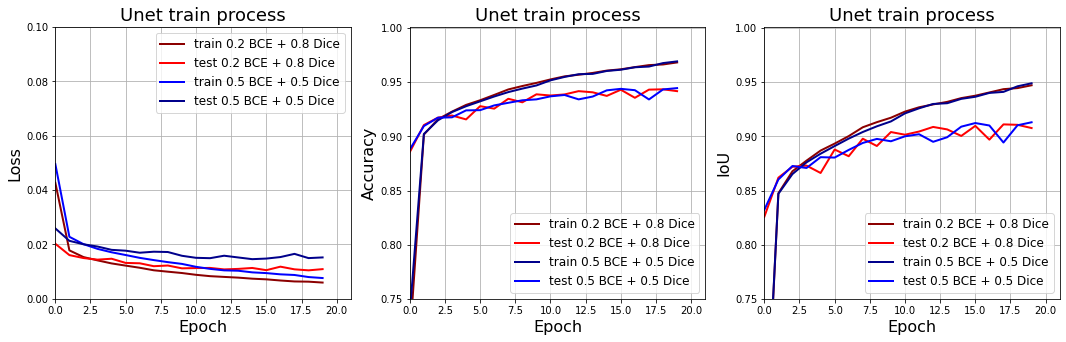

In [70]:
bce_test_losses, bce_test_metrics, bce_test_iou, bce_train_losses, bce_train_metrics, bce_train_iou  = modif_train_res
dice_test_losses, dice_test_metrics, dice_test_iou, dice_train_losses, dice_train_metrics, dice_train_iou = modif2_train_res
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(131)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.ylim(0.0, 0.1)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_losses, label="train 0.2 BCE + 0.8 Dice", color="darkred", linewidth=2)
plt.plot(dice_test_losses, label="test 0.2 BCE + 0.8 Dice", color="red", linewidth=2)
plt.plot(bce_train_losses, label="train 0.5 BCE + 0.5 Dice", color="blue", linewidth=2)
plt.plot(bce_test_losses, label="test 0.5 BCE + 0.5 Dice", color="darkblue", linewidth=2)
ax.legend(loc=1, fontsize=12)


ax = fig.add_subplot(132)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.ylim(0.75,1.001)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_metrics, label="train 0.2 BCE + 0.8 Dice", color="darkred", linewidth=2)
plt.plot(dice_test_metrics, label="test 0.2 BCE + 0.8 Dice", color="red", linewidth=2)
plt.plot(bce_train_metrics, label="train 0.5 BCE + 0.5 Dice", color="darkblue", linewidth=2)
plt.plot(bce_test_metrics, label="test 0.5 BCE + 0.5 Dice", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)


ax = fig.add_subplot(133)
plt.title("Unet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("IoU", fontsize=16)

plt.ylim(0.75,1.001)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_iou, label="train 0.2 BCE + 0.8 Dice", color="darkred", linewidth=2)
plt.plot(dice_test_iou, label="test 0.2 BCE + 0.8 Dice", color="red", linewidth=2)
plt.plot(bce_train_iou, label="train 0.5 BCE + 0.5 Dice", color="darkblue", linewidth=2)
plt.plot(bce_test_iou, label="test 0.5 BCE + 0.5 Dice", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)

plt.show()

### Предсказания Unet с функцией потерь 0.5 * BCEWithlogitsloss + 0.5 * DiceLoss

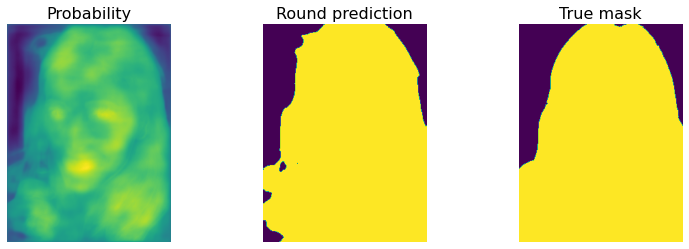

Accuracy: 0.972


In [51]:
net_predict(modif_unet, test_dataset, 4)

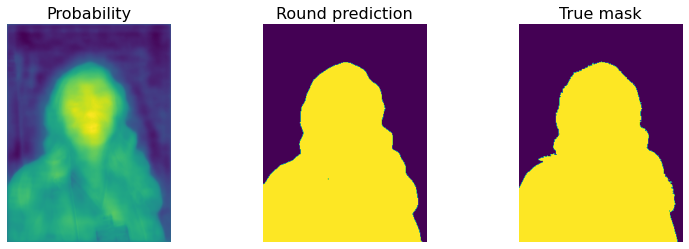

Accuracy: 0.990


In [52]:
net_predict(modif_unet, test_dataset, 30)

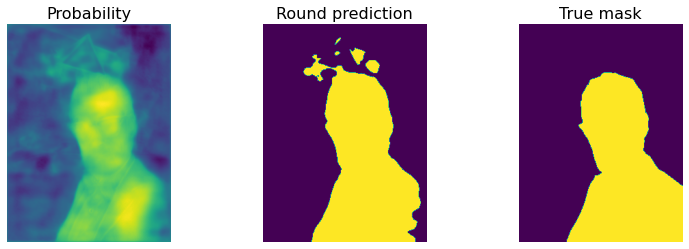

Accuracy: 0.956


In [53]:
net_predict(modif_unet, test_dataset, 120)

### Предсказания Unet с функцией потерь 0.2 * BCEWithlogitsloss + 0.8 * DiceLoss

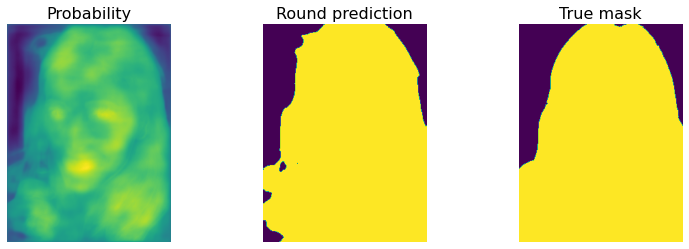

Accuracy: 0.972


In [54]:
net_predict(modif2_unet, test_dataset, 4)

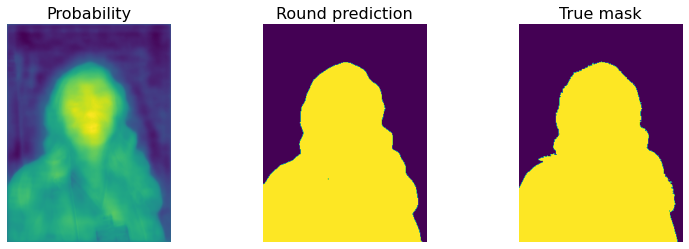

Accuracy: 0.990


In [55]:
net_predict(modif2_unet, test_dataset, 30)

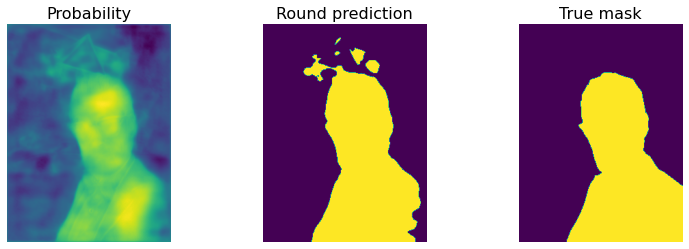

Accuracy: 0.956


In [56]:
net_predict(modif2_unet, test_dataset, 120)

Использование модифицированной функции потерь, хоть и добавляет вычислительной сложности, приводит только к ухудшению качества, относительно обычного DiceLoss.

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [57]:
class LinknetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x += left
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

In [58]:
class LinknetDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LinknetDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [59]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinknetDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [60]:
bce_linknet = LinkNet()
bce_linknet.to(cuda_1)
criterion = nn.BCEWithLogitsLoss()
val_criterion = accuracy_mean
optimizer = Adam(bce_linknet.parameters(), weight_decay=1e-5, lr=1e-5)

bce_linknet, bce_linknet_res = train(
    model=bce_linknet, 
    criterion=criterion, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:   1   Loss / Metric / IoU:  train: 0.060/0.729/0.563  test: 0.034/0.880/0.817
Epoch:   2   Loss / Metric / IoU:  train: 0.030/0.898/0.838  test: 0.029/0.900/0.843
Epoch:   3   Loss / Metric / IoU:  train: 0.026/0.912/0.859  test: 0.027/0.907/0.852
Epoch:   4   Loss / Metric / IoU:  train: 0.024/0.918/0.868  test: 0.026/0.910/0.857
Epoch:   5   Loss / Metric / IoU:  train: 0.023/0.925/0.878  test: 0.025/0.918/0.870
Epoch:   6   Loss / Metric / IoU:  train: 0.021/0.929/0.885  test: 0.024/0.926/0.885
Epoch:   7   Loss / Metric / IoU:  train: 0.020/0.934/0.892  test: 0.024/0.914/0.862
Epoch:   8   Loss / Metric / IoU:  train: 0.019/0.937/0.898  test: 0.027/0.895/0.830
Epoch:   9   Loss / Metric / IoU:  train: 0.018/0.940/0.902  test: 0.022/0.933/0.896
Epoch:  10   Loss / Metric / IoU:  train: 0.017/0.945/0.909  test: 0.021/0.932/0.893
Epoch:  11   Loss / Metric / IoU:  train: 0.017/0.946/0.912  test: 0.023/0.921/0.872
Epoch:  12   Loss / Metric / IoU:  train: 0.016/0.950/0.917  test

In [61]:
torch.save(bce_linknet.state_dict(), base_path + "models/bce_linknet")

In [62]:
dice_linknet = LinkNet()
dice_linknet.to(cuda_1)
criterion = DiceLoss(reduction="mean")
val_criterion = accuracy_mean
optimizer = Adam(dice_linknet.parameters(), weight_decay=1e-5, lr=1e-5)

dice_linknet, dice_linknet_res = train(
    model=dice_linknet, 
    criterion=criterion, 
    optimizer=optimizer,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    val_criterion=val_criterion,
    epochs=20, 
    device=cuda_1,
    show=True
)


Epoch:   1   Loss / Metric / IoU:  train: 0.036/0.645/0.564  test: 0.026/0.852/0.799
Epoch:   2   Loss / Metric / IoU:  train: 0.016/0.880/0.822  test: 0.011/0.904/0.857
Epoch:   3   Loss / Metric / IoU:  train: 0.010/0.909/0.859  test: 0.010/0.909/0.860
Epoch:   4   Loss / Metric / IoU:  train: 0.010/0.916/0.869  test: 0.010/0.915/0.869
Epoch:   5   Loss / Metric / IoU:  train: 0.009/0.922/0.877  test: 0.009/0.920/0.877
Epoch:   6   Loss / Metric / IoU:  train: 0.009/0.926/0.884  test: 0.009/0.922/0.880
Epoch:   7   Loss / Metric / IoU:  train: 0.008/0.932/0.892  test: 0.008/0.926/0.886
Epoch:   8   Loss / Metric / IoU:  train: 0.007/0.936/0.898  test: 0.008/0.928/0.888
Epoch:   9   Loss / Metric / IoU:  train: 0.007/0.939/0.902  test: 0.008/0.930/0.892
Epoch:  10   Loss / Metric / IoU:  train: 0.007/0.943/0.908  test: 0.008/0.932/0.894
Epoch:  11   Loss / Metric / IoU:  train: 0.006/0.945/0.911  test: 0.008/0.933/0.895
Epoch:  12   Loss / Metric / IoU:  train: 0.006/0.948/0.916  test

In [63]:
torch.save(dice_linknet.state_dict(), base_path + "models/dice_linknet")

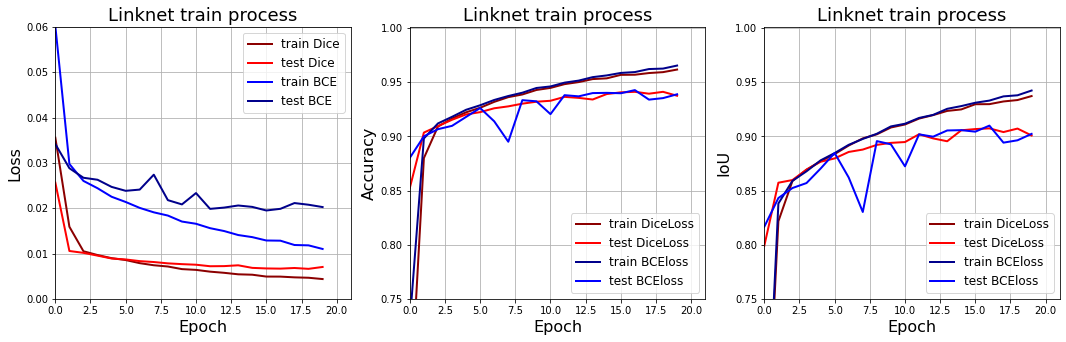

In [68]:
bce_test_losses, bce_test_metrics, bce_test_iou, bce_train_losses, bce_train_metrics, bce_train_iou = bce_linknet_res
dice_test_losses, dice_test_metrics, dice_test_iou, dice_train_losses, dice_train_metrics, dice_train_iou = dice_linknet_res

fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(131)
plt.title("Linknet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.ylim(0.0, 0.06)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_losses, label="train Dice", color="darkred", linewidth=2)
plt.plot(dice_test_losses, label="test Dice", color="red", linewidth=2)
plt.plot(bce_train_losses, label="train BCE", color="blue", linewidth=2)
plt.plot(bce_test_losses, label="test BCE", color="darkblue", linewidth=2)
ax.legend(loc=1, fontsize=12)


ax = fig.add_subplot(132)
plt.title("Linknet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.ylim(0.75,1.001)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_metrics, label="train DiceLoss", color="darkred", linewidth=2)
plt.plot(dice_test_metrics, label="test DiceLoss", color="red", linewidth=2)
plt.plot(bce_train_metrics, label="train BCEloss", color="darkblue", linewidth=2)
plt.plot(bce_test_metrics, label="test BCEloss", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)


ax = fig.add_subplot(133)
plt.title("Linknet train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("IoU", fontsize=16)

plt.ylim(0.75,1.001)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_iou, label="train DiceLoss", color="darkred", linewidth=2)
plt.plot(dice_test_iou, label="test DiceLoss", color="red", linewidth=2)
plt.plot(bce_train_iou, label="train BCEloss", color="darkblue", linewidth=2)
plt.plot(bce_test_iou, label="test BCEloss", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)

plt.show()

Сеть, обучаемая с функцией потерь DiceLoss обучается значительно стабильнее аналога с BCEWithlogitsloss, при этом достигая более высокого качества. Помимо этого, отклонение качества на тестовой выборке от качества на той, которая используется на обучении у сети, обучаемой с DiceLoss меньше, чем у сети с BCEWithlogitsloss.

## Linknet с BCEwithlogitsloss

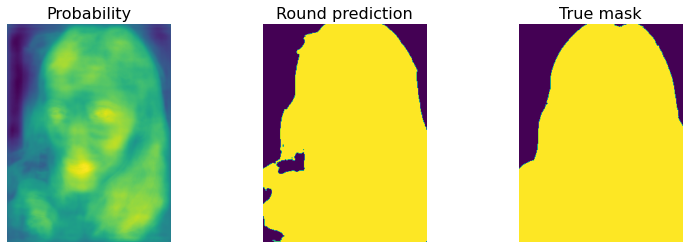

Accuracy: 0.966


In [75]:
net_predict(bce_linknet, test_dataset, 4)

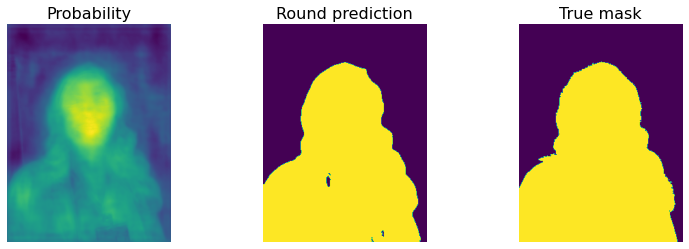

Accuracy: 0.986


In [76]:
net_predict(bce_linknet, test_dataset, 30)

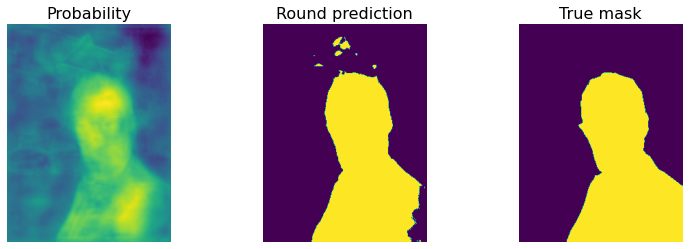

Accuracy: 0.968


In [77]:
net_predict(bce_linknet, test_dataset, 120)

## Linknet с DiceLoss

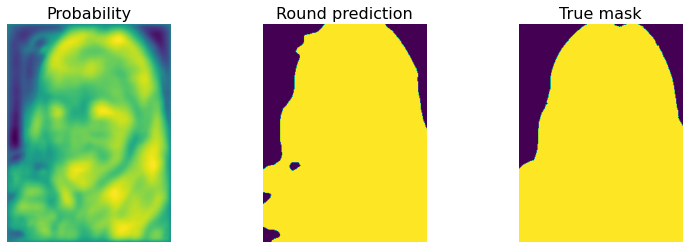

Accuracy: 0.976


In [71]:
net_predict(dice_linknet, test_dataset, 4)

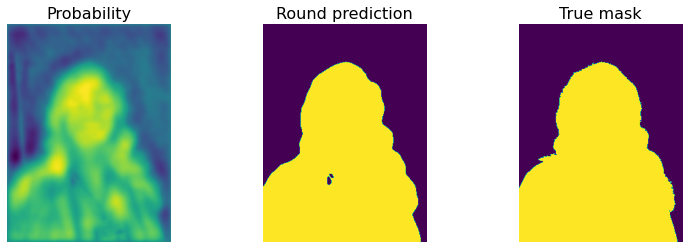

Accuracy: 0.989


In [72]:
net_predict(dice_linknet, test_dataset, 30)

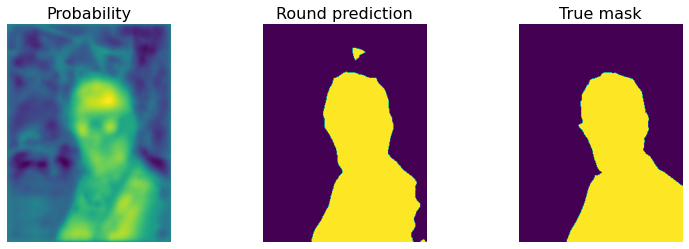

Accuracy: 0.971


In [73]:
net_predict(dice_linknet, test_dataset, 120)

У LinkNet на выведеных изображениях маски кажутся более точными. Меньше выбросов вне сегмента изображения и сам сегмент кажется более целостным. При этом с DiceLoss сегменты получаются более целостными, чем у BCELoss, что в общем-то ожидаемо из-за логики работы DiceLoss.

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

### Сравнение Linknet и Unet

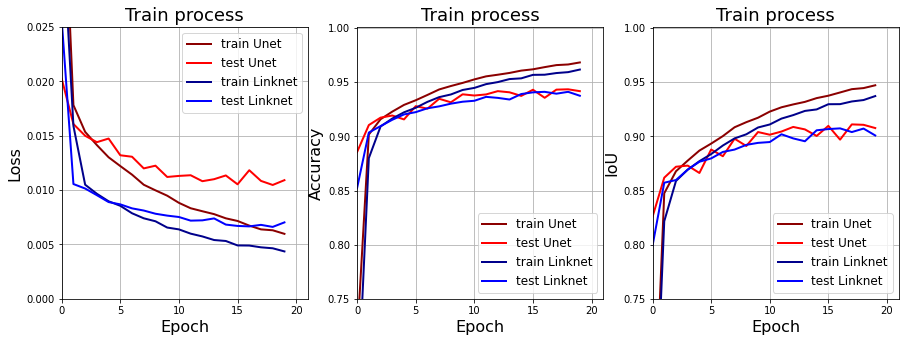

In [80]:
bce_test_losses, bce_test_metrics, bce_test_iou, bce_train_losses, bce_train_metrics, bce_train_iou = dice_linknet_res
dice_test_losses, dice_test_metrics, dice_test_iou, dice_train_losses, dice_train_metrics, dice_train_iou = dice_train_res

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
plt.title("Train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.ylim(0,0.025)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_losses, label="train Unet", color="darkred", linewidth=2)
plt.plot(dice_test_losses, label="test Unet", color="red", linewidth=2)
plt.plot(bce_train_losses, label="train Linknet", color="darkblue", linewidth=2)
plt.plot(bce_test_losses, label="test Linknet", color="blue", linewidth=2)
ax.legend(loc=1, fontsize=12)

ax = fig.add_subplot(132)
plt.title("Train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.ylim(0.75,1.001)
plt.xlim(0, 21)
ax.grid()
plt.plot(dice_train_metrics, label="train Unet", color="darkred", linewidth=2)
plt.plot(dice_test_metrics, label="test Unet", color="red", linewidth=2)
plt.plot(bce_train_metrics, label="train Linknet", color="darkblue", linewidth=2)
plt.plot(bce_test_metrics, label="test Linknet", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)

ax = fig.add_subplot(133)
plt.title("Train process", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("IoU", fontsize=16)

ax.grid()
plt.ylim(0.75,1.001)
plt.xlim(0, 21)
plt.plot(dice_train_iou, label="train Unet", color="darkred", linewidth=2)
plt.plot(dice_test_iou, label="test Unet", color="red", linewidth=2)
plt.plot(bce_train_iou, label="train Linknet", color="darkblue", linewidth=2)
plt.plot(bce_test_iou, label="test Linknet", color="blue", linewidth=2)
ax.legend(loc=4, fontsize=12)

plt.show()

Linknet имеет бОльшую обобщающую способность, чем Unet. Это можно увидеть по более равномерному графику функции потерь, точности и IoU, чем у Unet. При сравнении использоваласт функция потерь DiceLoss, как наиболее удачная в нашей задаче для каждой из моделей. Тем не менее обе сети получают сопоставимый результат, что неудивительно из-за схожести их архитектур.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

__Ответ:__

Поскольку вопрос ставится в общем виде, без уточнения о том, что имеются в виду архитектуры Unet и Linknet, то и ответ будет о предположениях, работающих в принципе в сверточных сетях. Не уверен, как эти предположения выделяются в литературе, но постараюсь описать их достаточно формально. Рассмотрим нейронную сеть, как алгоритм, способный выделять закономерности в данных. 

Первый вопрос
1. Геометрическое положение признаков несет важную информацию. А именно, закономерность содержится в соседних признаках. 
2. Одинаковые закономерности, находящиеся в разных частях объекта, несут одинаковую информацию об объекте.

Второй вопрос
1. Если рассмотреть один слой свертки, то в нем, свертка, при поиске закономерности, рассматривает только несколько соседних признаков (в зависимости от размера свертки)  зануляет остальные, которые находятся далеко. Конкретно в этом слое, свертка вносит априорную информацию, что искомая закономерность сожержится в комбинации признаков, находящихся в определенной ограниченной области. Еще одним плюсом свертки будет то, что таким образом мы сильно уменьшаем количество параметров, чем снижаем эффект переобучения.
2. Операция свертки, вносит априорную информацию о том, что закономерность может находится в любой части объекта, тем самым ограждая сеть от запоминания всевозможных положений этой закономерности. В случае обычного полносвязного слоя, такого инварианта мы не имеем, чем сильно перегружаем сеть.

Третий вопрос $$$$
Эти предположения выполянются в данных, имеющих или последовательную структуру, такие как звук, текст, видео, а так же в целостной структурной информации об объектах, представляющих собой унифицированное описание каждой его части (имеется в виду разбиение объекта на равные части). В простейшем случае это может быть изображением или некоторым покусочным описанием какой-то характеристики физического объекта (например температура какого-то физического объекта). В остальном виде информации эти предположения не работают.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

__Ответ:__

Пусть $x^{(i)}$ - вектор столбец $ x^{(i)} \in \mathbb{R}^{100 \times 1}$.
Тогда произведение $ W x^{(i)} \in \mathbb{R}^{1000 \times 1}$. Так как $\sigma $- работает поэлементно, она не меняет размерности пространства. Тогда размерность выходное пространство будет $\mathbb{R}^{1000 \times 1}$.
Функция активации сама по себе не имеет обучаемых параметров, поэтому в этом случае мы можем обучать только матрицу $W$, которая имеет $1000 \times 100 = 100 000$ обучаемых параметров. Для одного вектор-столбца $x^{(i)}$ размерности $100 \times 1$ при умножении на матрицу $W$ слева, выполняется  $1000 \times 100 = 100 000$ операций умножения (допустим сложности $m$, так как неизвестен способ реализации в torch.tensor) и $1000 \times 99 = 99 000$ операций сложения (допустим сложности $a$), плюс поэлементная функция активации, допустим некоторой сложности $s$. Тогда итоговая сложность будет:
$$D\left(f\right) = 100000m + 99000a + 1000s $$ $$$$

Рассмотрим свертку. Операция свертки размера 3 с $padding = 1$, переводит вектор $x^{(i)} \in \mathbb{R}^{100 \times 1}$, или же, что эквивалентно в нашем случае пространства $\mathbb{R}^{100 \times 1 \times 1}$, в пространство $\mathbb{R}^{100 \times 1 \times 10}$. Функция активации не меняет размерности пространства. В такой свертке с 10 картами признаков, количество обучаемых параметров будет равно $3 \times 10 = 30$. Имеем 100 - 2 = 98 операции применения свертки, каждая сложности $3m \times 10 = 30m$ для умножений, плюс $2a \times 10 = 20a$ сложений. А так же $(100 \times 10)s = 1000s$ для функции активации. Итого:
$$ D\left(g\right) = 98 \times \left(30m + 20a\right) + 1000s = 2940m + 1960a + 1000s$$




*Ваш ответ в этой ячейке*

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.